In [1]:
##################
### Author: Adriano Fonzino. email: adriano.fonzino@uniba.it Date: 11/2023
##################

# import basic modules
import os, sys, pysam, gzip
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sn
from tensorflow.python.platform.tf_logging import warn
from preprocessing_functions import from_2_to_3_dimensions
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
import keras
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

In [2]:
# define inputs (hek ADAR-KO for development purposes)
reditable_filepath = "/lustre/bio_running/A_to_I_Pietro/model_test_2023/hek_adar_samples/SRR5564268.ADAR1_KO/DnaRna_854894021/outTable_854894021.gz"
model_filepath = "/lustre/bio_running/A_to_I_Pietro/model_test_2023/src/kidney_dataset/cnn_wavenet_14112023/model_WaveNet_small_log_preprocessing14_11_2023_15_01_48.h5"
output_table_prefix_filepath = reditable_filepath
cov_threshold = 50
AGfreq_threshold = 0.01
interval = 101

#### START ####
# load the model
print(f"[{datetime.now()}] Loading model from:", model_filepath)
model = tf.keras.models.load_model(model_filepath)

starttime = datetime.now()

editing = []
# open reditools table (compressed and indexed via tabix)
with gzip.open(reditable_filepath) as redi:
    for c,l in enumerate(redi):
        line = l.decode("utf-8").rstrip().split("\t")
        if line[2] == "A":
            if line[4] != "-":
                if int(line[4]) >= cov_threshold:
                    if "AG" in line[7]:    
                        AG_rna = eval(line[6])[2]/sum(eval(line[6]))
                        if AG_rna >= AGfreq_threshold:
                            editing.append(line)
        if c % 50000000 == 0:
            print(f"\tSites evaluated: {c}")
print("Total evaluated rows:", c)
editing = pd.DataFrame(editing)
print("Total extracted Candidates Editing sites for current sample:", editing.shape[0])
stoptime = datetime.now()
print(f"[{datetime.now()}] Extraction of Editing Candidates finished for current sample. Elapsed time: {stoptime-starttime}.")

[2023-11-14 18:13:40.516524] Loading model from: /lustre/bio_running/A_to_I_Pietro/model_test_2023/src/kidney_dataset/cnn_wavenet_14112023/model_WaveNet_small_log_preprocessing14_11_2023_15_01_48.h5


2023-11-14 18:13:40.675659: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 18:13:41.236649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38263 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


	Sites evaluated: 0
	Sites evaluated: 150000000
	Sites evaluated: 200000000
	Sites evaluated: 250000000
	Sites evaluated: 300000000
	Sites evaluated: 350000000
	Sites evaluated: 400000000
	Sites evaluated: 450000000
	Sites evaluated: 500000000
Total evaluated rows: 519011879
Total extracted Candidates Editing sites for current sample: 37110
[2023-11-14 18:24:24.761122] Extraction of Editing Candidates finished for current sample. Elapsed time: 0:10:42.876991.


In [3]:
columns = ["Region", "Position", "Ref", "Strand", "Cov", "Qual", "[A,C,G,T]", "AllSubs", "Freq", "gCov", "gQual", "g[A,C,G,T]", "gAllSubs", "gFreq"]
editing.columns = columns
print()
print(editing)
print(f"[{datetime.now()}] Starting extraction of intervals.")


           Region Position Ref Strand Cov   Qual       [A,C,G,T] AllSubs  \
0            chrX   200841   A      1  88  35.55   [87, 0, 1, 0]      AG   
1            chrX   200848   A      1  81  36.65   [79, 1, 1, 0]   AG AC   
2            chrX   216920   A      1  69  40.29   [68, 0, 1, 0]      AG   
3            chrX   217745   A      1  58  39.17   [57, 0, 1, 0]      AG   
4            chrX   217747   A      1  59  38.56   [58, 0, 1, 0]      AG   
...           ...      ...  ..    ...  ..    ...             ...     ...   
37105  GL000191.1    40326   A      0  59  34.92   [58, 0, 1, 0]      AG   
37106  GL000191.1    45476   A      0  88  35.27   [87, 0, 1, 0]      AG   
37107  GL000191.1    47652   A      0  55  36.00   [54, 0, 1, 0]      AG   
37108  GL000218.1    47386   A      0  52  37.67  [26, 0, 26, 0]      AG   
37109  GL000218.1    47972   A      0  53  36.38   [52, 0, 1, 0]      AG   

       Freq gCov gQual g[A,C,G,T] gAllSubs gFreq  
0      0.01    -     -          -  

In [4]:
# create ohe instance
ohe = OneHotEncoder()
ohe.fit(np.array(["A", "C", "G", "T"]).reshape(-1, 1))

intervals = []
starttime_preds = datetime.now()
total_extracted = 0

features_extracted_filepath = output_table_prefix_filepath + ".feature_vectors.tsv"
features_extracted = open(features_extracted_filepath, "w")
# mantain only non chrM regions
df = editing.query("Region != 'chrM'")
print(f"[{datetime.now()}] Loading reditable with tabix and pysam:", reditable_filepath)
start_time = datetime.now()
srr = pysam.TabixFile(reditable_filepath)
# extract pos examples
with tqdm(total=df.shape[0], position=0, leave=True) as pbar:
    for site in df.itertuples():
        start = int(site.Position) - ((interval-1)/2)
        stop = int(site.Position) + ((interval-1)/2)
        AGrna = eval(site._7)[2]/sum(eval(site._7))
        srr_interval = []
        for s in srr.fetch(site.Region, start-1, stop):
            srr_interval.append(s.split("\t"))
        srr_interval = pd.DataFrame(srr_interval, columns=columns)
        # assess wheter interval is of the required length and if the entire interval is on the same strand
        if srr_interval.shape[0] == interval and len(set(srr_interval["Strand"])) == 1:
            intervals.append([site.Region, site.Position, site.Strand, AGrna, start, stop, stop-start + 1, srr_interval.shape[0]])
            total_extracted += 1
            strand = site.Strand
            # encode features vector and write to disk
            seq = srr_interval.Ref.values.reshape(-1,1)
            seq_ohe = ohe.transform(seq).toarray().T
            vects_freqs = []
            strands = []
            vects = []
            for vect in srr_interval["[A,C,G,T]"]:
                vect = np.array(eval(vect))
                cov = sum(vect)
                vect_freqs = vect / cov
                vects_freqs.append(vect_freqs)
                vects.append(vect)
            vects_freqs = np.array(vects_freqs).T
            vects = np.array(vects).T
            site = pd.concat([pd.DataFrame(seq_ohe), pd.DataFrame(vects_freqs)])
            if strand == 0: # flip horizontally if it is on reverse strand
                site = pd.DataFrame(np.flip(site.values, axis=1))
            # save to disk (append mode)
            site.to_csv(features_extracted, mode="a", sep="\t", header = None, index=None)
        pbar.update(1)
# create dataframe for editing sites candidates with complete intervaal
intervals = pd.DataFrame(intervals)
print(f"[{datetime.now()}] Total extracted Editing sites: {total_extracted}.")
stop_time_global = datetime.now()
print(f"[{datetime.now()}] Features Extraction Finished. Elapsed time {datetime.now()-starttime_preds}.")
features_extracted.close()

[2023-11-14 18:24:24.871601] Loading reditable with tabix and pysam: /lustre/bio_running/A_to_I_Pietro/model_test_2023/hek_adar_samples/SRR5564268.ADAR1_KO/DnaRna_854894021/outTable_854894021.gz


100%|██████████| 37089/37089 [02:11<00:00, 282.70it/s]


[2023-11-14 18:26:36.179201] Total extracted Editing sites: 16491.
[2023-11-14 18:26:36.179930] Features Extraction Finished. Elapsed time 0:02:11.324633.


In [5]:
# start prediction step on the extracted features
# loading features and preprocess these for inference
###--- START LOADING OF DATA ---###
print(f"Loading features extracted of editing candidates from: {features_extracted_filepath}")
X = pd.read_table(features_extracted_filepath, header=None)
# trasform into 3d tensor from series of 2d table from tsv input file
X_3d = from_2_to_3_dimensions(X, 8)
# create a log2 version on pseudo count to zoom differences among edited and non edited sites
# create a tuple containing min and max log2 expected values useful to normalize frequency features
log_range = (-13.28771238, 0.000144262)
# go to pseudofrequency
X_3d_log2 = X_3d.copy()
X_3d_log2[:,:,4:] = np.log2(X_3d_log2[:,:,4:]+0.0001)
# normalize log2 preudo-frequencies using log2 boudaries
X_3d_log2[:,:,4:] = (X_3d_log2[:,:,4:]-log_range[0]) / (log_range[1] - log_range[0])
X_3d_log2.shape

Loading features extracted of editing candidates from: /lustre/bio_running/A_to_I_Pietro/model_test_2023/hek_adar_samples/SRR5564268.ADAR1_KO/DnaRna_854894021/outTable_854894021.gz.feature_vectors.tsv


(16491, 101, 8)

In [22]:
# make prediction
y_hat_proba = model.predict(X_3d_log2, batch_size=100)
y_hat_proba

array([[3.8079500e-12, 1.0000000e+00],
       [7.8228309e-12, 1.0000000e+00],
       [4.6355611e-13, 1.0000000e+00],
       ...,
       [2.3756594e-10, 1.0000000e+00],
       [7.2282402e-10, 1.0000000e+00],
       [7.6211615e-09, 1.0000000e+00]], dtype=float32)

In [23]:
y_hat_proba.shape

(16491, 2)

In [8]:
# produce output vector (0 --> SNP; 1 --> Editing)
y_hat = np.array([np.argmax(i) for i in y_hat_proba])
y_hat

array([1, 1, 1, ..., 1, 1, 1])

In [9]:
np.unique(y_hat, return_counts=True)

(array([0, 1]), array([ 1362, 15129]))

In [10]:
# append to intervals
intervals["snp_proba"] = y_hat_proba[:,0]
intervals["ed_proba"] = y_hat_proba[:,1]
intervals["y_hat"] = y_hat
intervals.columns = ["region", "position", "Strand", "FreqAGrna", "start", "stop", "int_len", "TabixLen", "snp_proba", "ed_proba", "y_hat"]
# save to disk
intervals.to_csv(output_table_prefix_filepath+".predictions.tsv", sep="\t", index=None)
print(f"[{datetime.now()}] Predictions concluded. File saved to: {output_table_prefix_filepath+'.predictions.tsv'}")
print(f"[{datetime.now()}] Computation Finished. Total Elapsed time: {datetime.now()-starttime}")
intervals

[2023-11-14 18:26:42.366315] Predictions concluded. File saved to: /lustre/bio_running/A_to_I_Pietro/model_test_2023/hek_adar_samples/SRR5564268.ADAR1_KO/DnaRna_854894021/outTable_854894021.gz.predictions.tsv
[2023-11-14 18:26:42.366461] Computation Finished. Total Elapsed time: 0:13:00.482399


,region,position,Strand,FreqAGrna,start,stop,int_len,TabixLen,snp_proba,ed_proba,y_hat
0,chrX,216920,1,0.014493,216870.0,216970.0,101.0,101,3.807950e-12,1.0,1
1,chrX,218046,1,0.018868,217996.0,218096.0,101.0,101,7.822831e-12,1.0,1
2,chrX,219831,1,0.012987,219781.0,219881.0,101.0,101,4.635561e-13,1.0,1
3,chrX,221414,0,0.020000,221364.0,221464.0,101.0,101,6.269702e-09,1.0,1
4,chrX,230871,0,0.018182,230821.0,230921.0,101.0,101,4.301846e-10,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
16486,GL000191.1,39822,0,0.017241,39772.0,39872.0,101.0,101,4.266872e-13,1.0,1
16487,GL000191.1,39832,0,0.018182,39782.0,39882.0,101.0,101,2.612257e-11,1.0,1
16488,GL000191.1,40279,0,0.013699,40229.0,40329.0,101.0,101,2.375659e-10,1.0,1
16489,GL000191.1,47652,0,0.018182,47602.0,47702.0,101.0,101,7.228240e-10,1.0,1


<AxesSubplot:xlabel='y_hat', ylabel='FreqAGrna'>

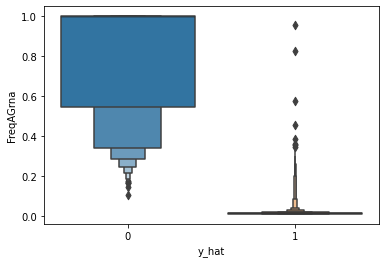

In [11]:
sn.boxenplot(data=intervals, x="y_hat", y="FreqAGrna")

<AxesSubplot:xlabel='y_hat', ylabel='FreqAGrna'>

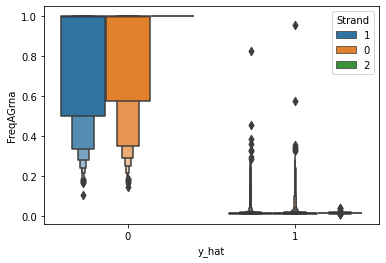

In [12]:
sn.boxenplot(data=intervals, x="y_hat", y="FreqAGrna", hue="Strand")